# Sharing and analyzing large scale data in the cloud

[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/pschmied/ire2022/blob/main/ire2022-talk-and-cheatsheet.ipynb)

(https://github.com/pschmied/ire2022)

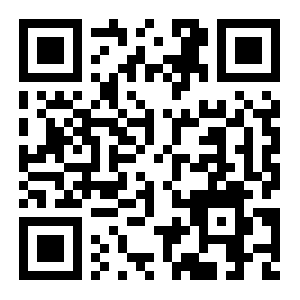

# Contacts / links
 - Peter Schmiedeskamp - Statistical & Regulatory Lead (pws AT amazon), AWS Open Data
 - AWS Open Data (opendata AT amazon / https://opendata.aws)
 - Registry of Open Data (https://registry.opendata.aws)

# Agenda

 - Brief discussion of a handful of AWS services that I think warrant attention (general, immediately useful, #frugal)
 - Deeper dive into cloud data storage and how to use it / look at a few real datasets
 - Interrogating large datasets with SQL
 - Discuss assembling / optimizing data for analysis
 - AWS Open Data and how we may be able to help you
 - Q&A 

# Recommended services to get started

 - [Amazon SageMaker Studio Lab](https://studiolab.sagemaker.aws/) :: Free notebook computing environment, CPU / GPU instances, no credit card signup. (this notebook!)
 - [Amazon Simple Storage Service (S3)](https://aws.amazon.com/s3/) :: Bedrock storage, foundation for storing, sharing, and analyzing data using variety of AWS and other (e.g. Open Source) tools.
 - [Amazon Athena](https://aws.amazon.com/athena/) :: High performance serverless SQL query engine works on objects stored in S3.
 - [AWS CloudShell](https://aws.amazon.com/cloudshell/) :: Free small instance Linux shell, preloaded with AWS tools. 
 - [Amazon EC2](https://aws.amazon.com/ec2/) :: Whatever kind of computer(s) you need, big or small. 

# S3 - accessing data

What is S3? Practically infinite, reliable, performant object storage. Enables AWS Open Data. Used by or used with nearly every AWS service—especially services aligned with the notion of a "data lake."

Data objects can contain any kind of data (images, music, CSVs, formats yet unknown to science). Max size of single object is 5TB

Let's look at some data from the [Registry of Open Data on AWS (RODA)](https://registry.opendata.aws). This example is from [Global Legal Identifier Foundation](https://registry.opendata.aws/lei/). Note we can explore the dataset in a variety of ways:

- AWS Console (requires being signed in to AWS, and some URL surgery if you don't own the bucket)
- [AWS Command Line Client]()
- 3rd-party graphical clients (e.g. [Cyberduck](https://cyberduck.io/))
- FUSE filesystem (e.g. [goofys](https://github.com/kahing/goofys))
- Programmatically via official SDKs (e.g. [Boto3](https://aws.amazon.com/sdk-for-python/) for Python), or 3rd-party SDKs (e.g. [PAWS](https://paws-r.github.io/) for R).

In this section I use the AWS CLI, and recommend it as a good balance of learning curve and power.

In [1]:
!aws --no-sign-request s3 ls s3://gleif/

                           PRE data/
2021-08-28 08:18:41      32357 index.html


In [2]:
!aws --no-sign-request s3 ls s3://gleif/data/csv/lei/date=2022-06-23/ --recursive --human-readable

2022-06-23 01:10:51  244.5 MiB data/csv/lei/date=2022-06-23/time=00:00/20220623-0000-gleif-goldencopy-lei.csv.gz
2022-06-23 09:10:55  244.5 MiB data/csv/lei/date=2022-06-23/time=08:00/20220623-0800-gleif-goldencopy-lei.csv.gz
2022-06-23 17:10:49  244.6 MiB data/csv/lei/date=2022-06-23/time=16:00/20220623-1600-gleif-goldencopy-lei.csv.gz


In [3]:
# Note the "/" is a lie - there are no directories in S3, only prefixes
!aws --no-sign-request s3 ls s3://gleif/data/csv/lei/date=2022-06-2 --recursive --human-readable

2022-06-20 01:10:56  244.0 MiB data/csv/lei/date=2022-06-20/time=00:00/20220620-0000-gleif-goldencopy-lei.csv.gz
2022-06-20 09:01:10  244.0 MiB data/csv/lei/date=2022-06-20/time=08:00/20220620-0800-gleif-goldencopy-lei.csv.gz
2022-06-20 17:31:02  244.1 MiB data/csv/lei/date=2022-06-20/time=16:00/20220620-1600-gleif-goldencopy-lei.csv.gz
2022-06-21 01:11:15  244.1 MiB data/csv/lei/date=2022-06-21/time=00:00/20220621-0000-gleif-goldencopy-lei.csv.gz
2022-06-21 09:11:02  244.2 MiB data/csv/lei/date=2022-06-21/time=08:00/20220621-0800-gleif-goldencopy-lei.csv.gz
2022-06-21 17:10:53  244.2 MiB data/csv/lei/date=2022-06-21/time=16:00/20220621-1600-gleif-goldencopy-lei.csv.gz
2022-06-22 01:10:51  244.3 MiB data/csv/lei/date=2022-06-22/time=00:00/20220622-0000-gleif-goldencopy-lei.csv.gz
2022-06-22 09:11:13  244.3 MiB data/csv/lei/date=2022-06-22/time=08:00/20220622-0800-gleif-goldencopy-lei.csv.gz
2022-06-22 17:11:12  244.4 MiB data/csv/lei/date=2022-06-22/time=16:00/20220622-1600-gleif-golde

In [4]:
# Downloading via the command line is easy
!aws --no-sign-request s3 cp s3://gleif/data/csv/lei/date=2022-06-23/time=16:00/20220623-1600-gleif-goldencopy-lei.csv.gz \
    ~/scratch/

download: s3://gleif/data/csv/lei/date=2022-06-23/time=16:00/20220623-1600-gleif-goldencopy-lei.csv.gz to ../scratch/20220623-1600-gleif-goldencopy-lei.csv.gz


In [5]:
# Yup it's there!
!ls -lah ~/scratch/

total 245M
drwxr-xr-x  2 studio-lab-user users     55 Jun 24 18:09 .
drwx------ 18 studio-lab-user nogroup 4.0K Jun 23 22:07 ..
-rw-r--r--  1 studio-lab-user users   245M Jun 23 17:10 20220623-1600-gleif-goldencopy-lei.csv.gz


In [6]:
# We can unzip it in place... assuming we have space
!gunzip ~/scratch/20220623-1600-gleif-goldencopy-lei.csv.gz

In [7]:
# How big is the uncompressed data?
!ls -lah ~/scratch/

total 1.5G
drwxr-xr-x  2 studio-lab-user users     52 Jun 24 18:09 .
drwx------ 18 studio-lab-user nogroup 4.0K Jun 23 22:07 ..
-rw-r--r--  1 studio-lab-user users   1.5G Jun 23 17:10 20220623-1600-gleif-goldencopy-lei.csv


In [8]:
# What if we want to make longitudinal comparisons back to 2018? How big is that?
!aws s3 ls s3://gleif/data/csv/lei/ --no-sign-request --recursive --summarize --human-readable | tail -2

Total Objects: 4791
   Total Size: 793.3 GiB


Assuming the \~6.2x compression ratio is the same for all files, downloading and decompressing these data would require >\~4,900GB of disk space. That's "only" 4.7 TiB (a mighty big laptop). But, if you had a 1TiB drive, managed disk space very carefully, left the data compressed, then processed the data very efficiently, decompressing and summarizing a bit of data at a time... 🤕

Also, to download over e.g. a 100Mb/s home broadband connection is ~6,492,979 seconds or 75 days (checking my math... 792.6GiB * 8bits * 1024Mib / 60sec / 60min / 24hr = ~75)

Looking at a larger dataset like [Sentinel 2](https://registry.opendata.aws/sentinel-2/), which is currently ~9.5PiB of satellite imagery. Not a fair comparison. However, the index of Sentinel 2 is tabular and helps us illustrate some concepts (currently ~40TiB for two formats, CSV and Apache ORC).

In [9]:
# Note that the index has too many objects to list in their entirety by conventional means in this session
!aws s3 ls s3://sentinel-inventory/sentinel-s2-l2a/sentinel-s2-l2a-inventory/data/ \
    --no-sign-request --recursive --human-readable \
    |head -n10

2022-06-24 15:17:55    0 Bytes sentinel-s2-l2a/sentinel-s2-l2a-inventory/data/
2020-01-11 19:08:36    1.1 MiB sentinel-s2-l2a/sentinel-s2-l2a-inventory/data/00000e73-8529-46a6-867c-8101ca771acb.csv.gz
2019-10-03 20:28:44    2.3 MiB sentinel-s2-l2a/sentinel-s2-l2a-inventory/data/00001686-23f5-4523-ae1d-16defdf0ce73.csv.gz
2019-09-11 20:53:48    2.4 MiB sentinel-s2-l2a/sentinel-s2-l2a-inventory/data/0000234a-6ae7-402a-aa88-31f73a940edd.csv.gz
2021-09-27 16:15:53   16.8 MiB sentinel-s2-l2a/sentinel-s2-l2a-inventory/data/00002854-2cc4-4b2a-91b8-0a2efa634bd9.csv.gz
2021-09-06 20:10:34    5.9 MiB sentinel-s2-l2a/sentinel-s2-l2a-inventory/data/000035b6-d2ec-4f98-b093-af464e6e6acf.csv.gz
2021-11-06 19:06:11    6.2 MiB sentinel-s2-l2a/sentinel-s2-l2a-inventory/data/000046e5-1ed0-4753-b8ef-17ea7fbdaad2.csv.gz
2020-03-13 20:18:46    2.2 MiB sentinel-s2-l2a/sentinel-s2-l2a-inventory/data/00004886-aa32-45da-82f6-a3f100ea6b01.csv.gz
2021-05-05 15:57:42    6.0 MiB sentinel-s2-l2a/sentinel-s2-l2a-inve

In [10]:
# Let's take a quick look at one of those; note output is pipeable!
!aws s3 --no-sign-request cp s3://sentinel-inventory/sentinel-s2-l2a/sentinel-s2-l2a-inventory/data/00005812-6c1b-44c5-89d7-2370785d4026.csv.gz - \
    | gunzip - | head -n10

"sentinel-s2-l2a","tiles/22/M/BT/2019/3/15/0/qi/SENSOR_QUALITY.xml","3107","2019-03-16T08:19:07.000Z"
"sentinel-s2-l2a","tiles/22/M/BT/2019/3/15/0/qi/SNW_20m.jp2","24261","2019-03-16T08:19:07.000Z"
"sentinel-s2-l2a","tiles/22/M/BT/2019/3/15/0/qi/SNW_60m.jp2","13364","2019-03-16T08:19:07.000Z"
"sentinel-s2-l2a","tiles/22/M/BT/2019/3/15/0/tileInfo.json","54291","2019-03-16T08:19:07.000Z"
"sentinel-s2-l2a","tiles/22/M/BT/2019/3/18/0/R10m/AOT.jp2","523315","2019-03-19T00:36:52.000Z"
"sentinel-s2-l2a","tiles/22/M/BT/2019/3/18/0/R10m/B02.jp2","59050644","2019-03-19T00:36:52.000Z"
"sentinel-s2-l2a","tiles/22/M/BT/2019/3/18/0/R10m/B03.jp2","59105745","2019-03-19T00:36:52.000Z"
"sentinel-s2-l2a","tiles/22/M/BT/2019/3/18/0/R10m/B04.jp2","57238747","2019-03-19T00:36:52.000Z"
"sentinel-s2-l2a","tiles/22/M/BT/2019/3/18/0/R10m/B08.jp2","62807437","2019-03-19T00:36:52.000Z"
"sentinel-s2-l2a","tiles/22/M/BT/2019/3/18/0/R10m/TCI.jp2","50550877","2019-03-19T00:36:52.000Z"

gzip: stdout: Broken pipe
down

# Athena - SQL analysis for large tabular data in S3

What is Athena? Athena is a distributed, serverless database engine. High reward to effort and cost.

Athena needs three things: data, schema, (often) index of partitions.

Data are stored as objects in S3 in [a variety of formats](https://docs.aws.amazon.com/athena/latest/ug/supported-serdes.html) (CSV, other delimited text, NDJSON, Parquet, ORC, etc). Objects are mapped to a relational schema via Data Definition Language (DDL). Partitions are represented as dimensions (columns) in the schema, and are either enumerated in AWS Glue catalog (or external Hive metastore), or inferred via Athena Partition Projection. Note Partition Projection is Athena-only, and doesn't apply to e.g. Glue.

CSV

```sql
CREATE EXTERNAL TABLE `sentinel_s1_l1c_inventory_csv`(
  `bucket` string COMMENT 'from deserializer', 
  `key` string COMMENT 'from deserializer', 
  `size` string COMMENT 'from deserializer', 
  `last_modified_date` string COMMENT 'from deserializer')
PARTITIONED BY ( 
  `dt` string)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.SymlinkTextInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
  's3://sentinel-inventory/sentinel-s1-l1c/sentinel-s1-l1c-inventory/hive'
```

ORC

```sql
CREATE EXTERNAL TABLE `sentinel_s1_l1c_inventory_orc`(
  `bucket` string, 
  `key` string, 
  `size` bigint, 
  `last_modified_date` timestamp)
PARTITIONED BY ( 
  `dt` string)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.ql.io.orc.OrcSerde' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.SymlinkTextInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
  's3://sentinel-inventory/orc/sentinel-s1-l1c/sentinel-s1-l1c-inventory-orc/hive'
```

Note: If following along, you will need to select "load partitions" from table menu.


### Query performance ORC vs. CSV
Why is the inventory available in two formats?

ORC
```sql
SELECT AVG(SIZE) FROM sentinel_s1_l1c_inventory_orc
```
(Run time: 3 min 22.992 sec / Data scanned: 77.73 GB)

vs. CSV

```sql
SELECT AVG(SIZE) FROM sentinel_s1_l1c_inventory_csv
```
(Run time: 15 min 32.688 sec / Data scanned: 356.02 GB)

# Assembling a dataset yourself

1. If you have the data, and they are small enough, upload to your S3 bucket via aws cli or other tools previously mentioned. (Our onboarding [Onboarding Handbook for Data Providers](https://assets.opendata.aws/aws-onboarding-handbook-for-data-providers-en-US.pdf) has some helpful advice about bucket layout and cli performance tuning.)

2. If you don't already have the data, but will be downloading and assembling from other sources, skip downloading to your laptop and download with AWS services directly to S3 (SMSL, CloudShell, EC2, etc). AWS probably has faster internet access than you, and definitely has faster network access to S3! There is also a good chance whoever you're downloading from is either on AWS or someone 

3. First pass optimizations: unarchive data (tar.gz, zip), pre-sort objects into useful prefixes using [Hive conventions](https://docs.aws.amazon.com/athena/latest/ug/partitions.html), if you can choose output format choose Parquet/ORC or JSON over CSV, compress individual objects (parquet.gz, csv.gz, ndjson.gz).

4. Second pass optimizations: Optimize the [partition structure of your data](https://docs.aws.amazon.com/athena/latest/ug/partitions.html) and convert to Parquet or ORC if you weren't able to initially. Tip: You can use Athena to reshuffle partitions and convert to optimized formats like Parquet and ORC using ["Create Table AS" queries](https://docs.aws.amazon.com/athena/latest/ug/ctas.html)

5. Email me if you're stuck! I can't promise in-depth help on every problem, but I am happy to give pointers, recommendations, and even code samples on slow news days.

# Support from AWS Open Data

- [Cover cost of hosting datasets](https://aws.amazon.com/opendata/open-data-sponsorship-program/) that you wish to share (reproducible research!)
- Technical guidance around building datasets
- Credits to pay for computing used to assemble open datasets
- Opportunities and assistance showcasing your data skills around open data

# Thank you! Contacts / links one last time
 - Peter Schmiedeskamp - Statistical & Regulatory Lead (pws AT amazon), AWS Open Data
 - AWS Open Data (opendata AT amazon / https://opendata.aws)
 - Registry of Open Data (https://registry.opendata.aws)